# Household analysis code

This is the methods for the ONS CIS household study https://arxiv.org/abs/2104.04605 applied to open data from:

Lavezzo, E., Franchin, E., Ciavarella, C. et al. Suppression of a SARS-CoV-2 outbreak in the Italian municipality of Vo. Nature 584, 425–429 (2020). https://doi.org/10.1038/s41586-020-2488-1

This version produces the EDA and residual-based plots; regression analysis to follow.


In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as st
import scipy.optimize as op
import pandas as pd
from numpy import linalg as LA
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
import pickle
from itertools import combinations

In [2]:
with open("./Y.pickle", "rb") as f:
    Y = pickle.load(f)
with open("./XX.pickle", "rb") as f:
    XX = pickle.load(f)

In [3]:
m = len(Y)

## Histograms

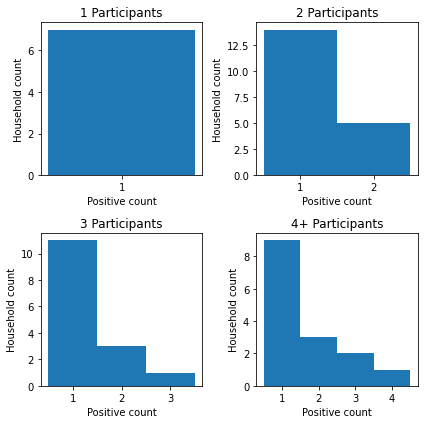

In [4]:
n = np.zeros(m)
y = np.zeros(m)
for i in range(0,m):
    n[i] = len(Y[i])
    y[i] = np.sum(Y[i])
    
plt.figure(figsize=(6,6))

for nn in range(1,4):
    plt.subplot(2,2,nn)
    yy = y[n==nn]
    counts, bins, bars = plt.hist(yy,bins=np.arange(0.5,nn+1.5,1))
    plt.title(str(nn) + ' Participants')
    plt.xlabel('Positive count')
    plt.ylabel('Household count')
    plt.xticks(np.arange(1,nn+1))

plt.subplot(2,2,4)
yy = y[n>=4]
counts, bins, bars = plt.hist(yy,bins=np.arange(0.5,5.5,1))
plt.title('4+ Participants')
plt.xlabel('Positive count')
plt.ylabel('Household count')
plt.tight_layout()

## Density plot

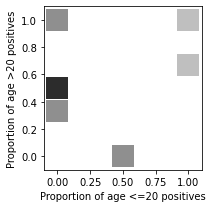

In [5]:
w = []
for i in range(0,m):
    mm = len(Y[i])
    if (np.sum(Y[i]) > 0):
        nkids = np.sum(XX[i])
        nadults = mm-nkids
        npos = np.sum(Y[i])
        nkpos = np.sum(np.sum(XX[i],1)*Y[i])
        napos = npos-nkpos
        if (nadults>0) and (nkids>0):
            w.append([nkpos/nkids,napos/nadults])
ww = np.array(w)

plt.figure(figsize=(3,3))
plt.scatter(ww[:,0],ww[:,1],marker='s',s=500,alpha=0.25,linewidths=0,c='k')
plt.xlabel('Proportion of age <=20 positives')
plt.ylabel('Proportion of age >20 positives')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.tight_layout()

## Pair and Residual Plots

These are done by age: Negative; Young positives; Old positives.


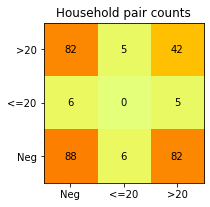

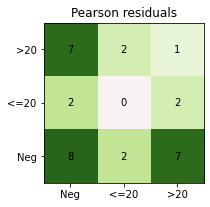

In [6]:
y = np.zeros((3,3))
z = np.zeros((3))

na = []

for i in range(0,len(Y)):
    if (np.sum(Y[i]) > 0):
        na.append(len(Y[i]))
        xx = np.zeros(len(Y[i]))
        for k in range(0,len(Y[i])):
            if (Y[i][k] > 0):
                if (XX[i][k][0] == 1):
                    xx[k] = 1
                else:
                    xx[k] = 2

        for comb in combinations(range(0,len(xx)),2):
            y[int(xx[comb[0]]),int(xx[comb[1]])] += 1
            y[int(xx[comb[1]]),int(xx[comb[0]])] += 1
        for x in xx:
            z[int(x)] += 1

n = np.sum(z)
pp = z/n
nn = np.array(na)
e = np.outer(z,z)/n
r = (y-e)/np.sqrt(e)

plt.figure(figsize=(3,3))
plt.imshow(y,origin='lower')
plt.xticks([0,1,2],['Neg','<=20','>20'])
plt.yticks([0,1,2],['Neg','<=20','>20'])
for (jj,ii),label in np.ndenumerate(y):
    plt.text(ii,jj,str(int(label)),ha='center',va='center')
plt.title('Household pair counts')
plt.set_cmap('Wistia')
plt.tight_layout()

plt.figure(figsize=(3,3))
plt.imshow(r,origin='lower',vmin=-8,vmax=8)
plt.xticks([0,1,2],['Neg','<=20','>20'])
plt.yticks([0,1,2],['Neg','<=20','>20'])
for (jj,ii),label in np.ndenumerate(r):
    plt.text(ii,jj,str(int(label)),ha='center',va='center')
plt.title('Pearson residuals')
plt.set_cmap('PiYG')
plt.tight_layout()